In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

In [3]:
from random_features import RFF

In [4]:
sampler = lambda shape: multivariate_normal(mean=[0]*3, cov=np.eye(3)).rvs(size=np.product(shape))

In [5]:
n_features = 20
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=3)

In [6]:
pts = np.arange(0, 1, 0.1).reshape(-1, 1).repeat(3, axis=1)

In [7]:
features = rff.get_random_features(pts)

In [8]:
assert features.shape == (len(pts), n_features)

# Main Part

In [9]:
from data_utils import Landscape

In [10]:
landscape = Landscape(num_landmarks=20)
landscape.initialize()

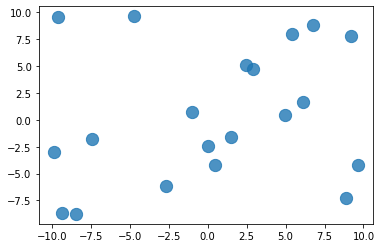

In [11]:
plt.scatter(landscape.landmarks[:, 0], landscape.landmarks[:, 1], s=150, alpha=0.8)

In [51]:
from data_utils import Odometry

N_pts = 100

odometry = Odometry(landscape, 
                    observation_dim=3, 
                    max_time=10, 
                    max_landmarks_per_step=1)
odometry.generate(N_pts)

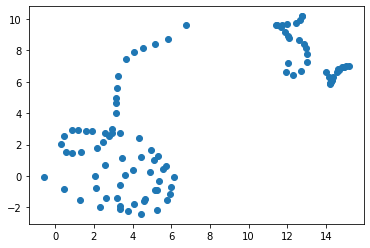

In [52]:
plt.scatter(np.array(odometry.states)[:, 0], np.array(odometry.states)[:, 1])

In [53]:
odometry.observations[0]

array([[ 2.03991249, -5.3899696 , 16.        ]])

In [121]:
from model import Model
from observation import RangeModel, RangeBearingModel 
from data_utils import get_prediction

state_dim = 3
landmark_dim = 2
obs_dim = 1

sigma_l = 3.
b_sigma = 1
land_sigma = 10
damppening_factor = 0.5

sampler = lambda shape: multivariate_normal(mean=[0], cov=(1./sigma_l**2)*np.eye(1)).rvs(size=np.product(shape))

n_features = 100
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=1)

range_model = RangeModel(range_noise_std=odometry.Q[0,0]**.5)

def prior_mean(t, state_estimates):
    i = odometry.times.index(t)
    state = get_prediction(state_estimates[i], odometry.motions[i])
    return state

#initial_values = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])
initial_values = np.zeros((n_features*state_dim)+len(landscape.landmarks)*landmark_dim)
b_means = np.zeros(n_features*state_dim)
land_means = np.zeros((len(landscape.landmarks), landmark_dim))

observations = range_model.filter_odom_observations(odometry.observations)

model = Model(rff=rff, 
              initial_values=initial_values,
              initial_state=odometry.states[0],
              times=odometry.times,
              measurements=observations,
              measurement_covs=[odometry.Q[:1, :1]] * N_pts,
              motions=odometry.motions,
              b_means=b_means,
              b_covs=[b_sigma**2 * np.eye(n_features)] * state_dim,
              land_means=land_means,
              land_cov=[land_sigma**2 * np.eye(landmark_dim)] * len(landscape.landmarks),
              observation_model=range_model,
              prior_mean=prior_mean,
              dampening_factor=damppening_factor,
            )

In [122]:
model.run_slam(1000)

Iter 0. Norm of perturbation: 27.0972
Iter 10. Norm of perturbation: 21.0756
Iter 20. Norm of perturbation: 21.9106
Iter 30. Norm of perturbation: 23.7063
Iter 40. Norm of perturbation: 23.6662
Iter 50. Norm of perturbation: 22.8002
Iter 60. Norm of perturbation: 21.8215
Iter 70. Norm of perturbation: 24.1647
Iter 80. Norm of perturbation: 22.9862
Iter 90. Norm of perturbation: 18.9431
Iter 100. Norm of perturbation: 26.7633
Iter 110. Norm of perturbation: 17.8369
Iter 120. Norm of perturbation: 20.1250
Iter 130. Norm of perturbation: 20.4374
Iter 140. Norm of perturbation: 25.7499
Iter 150. Norm of perturbation: 21.8838
Iter 160. Norm of perturbation: 18.7187
Iter 170. Norm of perturbation: 25.6920
Iter 180. Norm of perturbation: 23.0268
Iter 190. Norm of perturbation: 24.2661
Iter 200. Norm of perturbation: 19.4010
Iter 210. Norm of perturbation: 24.8218
Iter 220. Norm of perturbation: 20.2965
Iter 230. Norm of perturbation: 20.5401
Iter 240. Norm of perturbation: 22.8656
Iter 250. N

KeyboardInterrupt: 

In [41]:
odometry.Q

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0.,   0.]])

In [120]:
from model import Model
from observation import RangeModel, RangeBearingModel 
from data_utils import get_prediction

state_dim = 3
landmark_dim = 2
obs_dim = 2

sigma_l = 3.
b_sigma = 0.1
land_sigma = 1
damppening_factor = 0.5

sampler = lambda shape: multivariate_normal(mean=[0], cov=(1./sigma_l**2)*np.eye(1)).rvs(size=np.product(shape))

n_features = 100
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=1)

range_bearing_model = RangeBearingModel(range_noise_std=odometry.Q[0,0]**.5, bearing_noise_std=odometry.Q[1,1]**.5)

def prior_mean(t, state_estimates):
    i = odometry.times.index(t)
    state = get_prediction(state_estimates[i], odometry.motions[i])
    return state

#initial_values = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])
initial_values = np.zeros((n_features*state_dim)+len(landscape.landmarks)*landmark_dim)
b_means = np.concatenate([np.zeros(n_features*state_dim), landscape.landmarks.reshape(-1)])

observations = odometry.observations

model = Model(rff=rff, 
              initial_values=initial_values,
              initial_state=odometry.states[0],
              times=odometry.times,
              measurements=observations,
              measurement_covs=[odometry.Q[:obs_dim, :obs_dim]] * N_pts,
              motions=odometry.motions,
              b_means=b_means,
              b_covs=[b_sigma**2 * np.eye(n_features)] * state_dim,
              land_means=landscape.landmarks,
              land_cov=[land_sigma**2 * np.eye(landmark_dim)] * len(landscape.landmarks),
              observation_model=range_bearing_model,
              prior_mean=prior_mean,
              dampening_factor=damppening_factor,
            )

In [113]:
model.run_slam(1000)

ValueError: operands could not be broadcast together with shapes (340,) (380,) 

In [116]:
np.array(odometry.states[1:11])#, np.array(odometry.states[:10])+np.array(odometry.motions[:10])

array([[ 0.45754072, -0.86236584, -0.60242735],
       [ 1.30037816, -1.53431109, -0.4125175 ],
       [ 2.30359388, -2.00195916, -0.10660064],
       [ 3.36936569, -2.08913509,  0.19854265],
       [ 4.6167791 , -1.57773289,  0.74226838],
       [ 5.27918495, -0.88226943,  1.10416442],
       [ 5.57665508,  0.43958916,  2.19147794],
       [ 5.11126241,  1.03712242,  2.98756585],
       [ 4.43932719,  1.19108721, -2.94473483],
       [ 3.45944573,  1.11039475, -2.42025498]])

In [117]:
model.prior_means[:10]

[array([ 0.0979833 , -0.5829394 , -0.53261702]),
 array([4.62738612, 2.98864047, 1.1918622 ]),
 array([ 5.40237962, -0.05607128,  0.32882635]),
 array([6.79651614, 3.48742119, 1.44682868]),
 array([8.73976886, 0.88514913, 1.33499831]),
 array([ 4.83496351, 10.64129218, -2.13307332]),
 array([ 5.67133848,  6.29315727, -2.85227413]),
 array([ 8.37210903,  8.27876436, -2.85465057]),
 array([ 8.24501748,  4.3385691 , -2.78195278]),
 array([7.93863044, 4.24584967, 2.36659793])]

In [118]:
model.states[:10]

array([[ 0.21438218, -0.24853439, -1.54361922],
       [ 4.46304883,  3.23996637,  0.18972414],
       [ 5.81717374,  0.23512649, -0.6853891 ],
       [ 6.65904798,  3.78527492,  0.44235698],
       [ 8.22210621,  0.84908404,  0.34692831],
       [ 3.78466766, 10.11970516,  3.13654085],
       [ 6.73197529,  6.75845193,  2.45888611],
       [ 7.85862398,  7.46895793,  2.42389756],
       [ 8.06856861,  4.4538983 ,  2.49772329],
       [ 7.21253729,  3.88291616,  1.37728348]])

In [119]:
model.b[300:].reshape(-1, 2), landscape.landmarks

(array([[ -0.1116782 ,  -0.7960919 ],
        [  0.84255559,  -4.14378204],
        [ -4.84522515,  -1.34212288],
        [  4.79390365,  -9.35933625],
        [  1.57248232,   0.68966133],
        [  8.20130568,  -1.96728116],
        [  0.45223347,  -0.4491587 ],
        [  3.07216207,   2.11872944],
        [ -0.08264285,  -0.79376779],
        [ -2.42760253,  -3.10474309],
        [ -0.52061741,   3.50977226],
        [  0.525183  ,   1.362077  ],
        [  3.18443626,  -1.02382406],
        [-10.78737502,   2.02046199],
        [ -0.02017703,  -0.02017703],
        [ -0.46504874,   2.2048509 ],
        [  4.17324749,   2.22020934],
        [  4.43830604,  -2.44675056],
        [  0.25710607,   0.12335388],
        [  5.72159677,  -4.43371488]]),
 array([[ 9.17347416e+00,  7.77815073e+00],
        [-2.65473047e+00, -6.16108079e+00],
        [ 9.65915461e+00, -4.19977169e+00],
        [ 2.44586781e+00,  5.14103549e+00],
        [-8.44733943e+00, -8.74959598e+00],
        [ 2.876045